# Multiple Linear Regression

Multiple linear regression is the extension of simple linear regression to multiple explanatory variables and picks up means by group along the way.  Hence, multiple linear regression seeks to explain a single, numerical response variable using multiple explanatory variables of different types.

It helps to immediately visualize what the combination of multiple explanatory variables of different types adds to simple linear regression.  Consider the dataset $\texttt{carnivora}$.  We'll fit four different models using body weight $\texttt{SW}$ as the numerical response variable, birth weight $\texttt{BW}$ as a numerical explanatory variable, and Super Family as a categorical explanatory variable.  The four models are simple linear regression, multiple linear regression with unique intercepts for the levels of the categorical explanatory variable, multiple linear regression with unique slopes for the levels of the categorical explanatory variable, and multiple linear regression with unique intercepts and unique slopes for the levels of the categorical explanatory variable.

In [1]:
library(ggplot2)
library(dplyr)
carnivora <- read.csv("https://raw.githubusercontent.com/roualdes/data/master/carnivora.csv")
carn <- carnivora %>%
    select(BW, SW, SuperFamily) %>%
    na.omit


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
update_geom_defaults("point", list(colour = "blue"))
update_geom_defaults("density", list(colour = "blue"))
update_geom_defaults("path", list(colour = "blue"))
old <- theme_set(theme_bw() + theme(text = element_text(size=18)))

Much of the code to fit any one of the four models is not particularly new nor challenging.  The only real difference shows up in $\texttt{model.matrix()}$.  Pay some attention to how R code changes the model specification.

In [3]:
ll <- function(beta, y, mX) {
    sum((y - apply(mX, 1, function(row) {sum(beta * row)}))^2)
}
X <- model.matrix( ~ BW, data=carn)
X_ints <- model.matrix( ~ SuperFamily + BW, data=carn)
X_slps <- model.matrix( ~ SuperFamily:BW, data=carn)
X_ints_slps <- model.matrix( ~ SuperFamily + BW + SuperFamily:BW, data=carn)

beta_hat <- optim(rexp(2), ll, method="L-BFGS-B", mX=X, y=carn$SW)$par
beta_hat_ints <- optim(rexp(3), ll, method="L-BFGS-B", mX=X_ints, y=carn$SW)$par
beta_hat_slps <- optim(rexp(3), ll, method="L-BFGS-B", mX=X_slps, y=carn$SW)$par
beta_hat_ints_slps <- optim(rexp(4), ll, method="L-BFGS-B", mX=X_ints_slps, y=carn$SW)$par

The code below uses the four vectors of estimated coefficients to make a faceted plot, where each panel corresponds to the respective model matrix.  Each panel is labelled to help you identify what your options are for modeling within the framework of multiple linear regression.

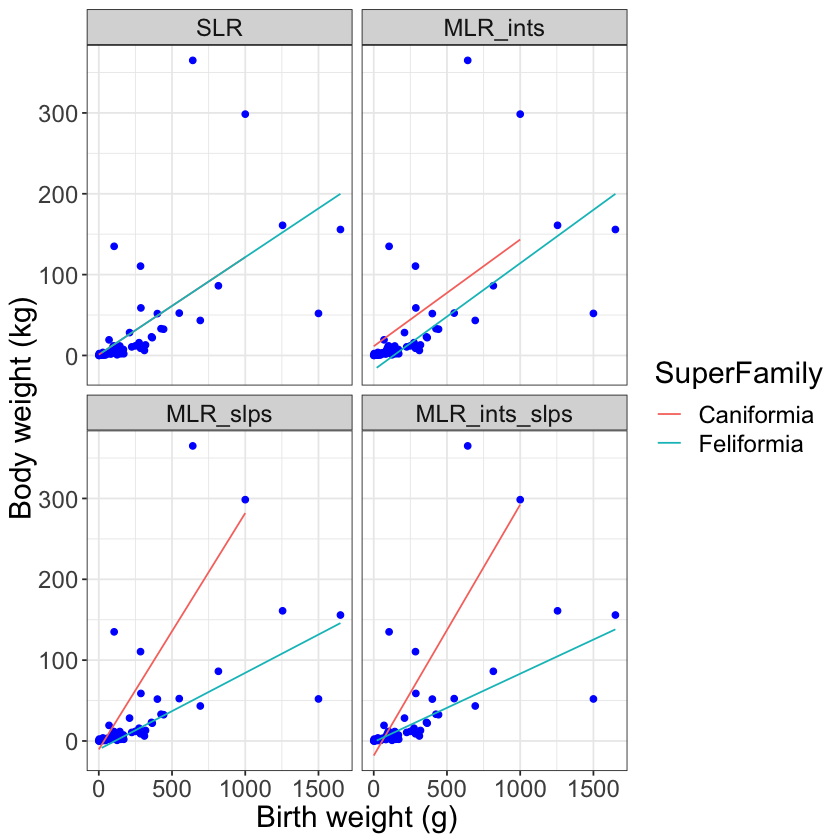

In [4]:
y_hat <- apply(X, 1, function(row) {sum(beta_hat * row)})
y_hat_ints <- apply(X_ints, 1, function(row) {sum(beta_hat_ints * row)})
y_hat_slps <- apply(X_slps, 1, function(row) {sum(beta_hat_slps * row)})
y_hat_ints_slps <- apply(X_ints_slps, 1, function(row) {sum(beta_hat_ints_slps * row)})

N <- nrow(X)
df <- data.frame(y_hat = c(y_hat, y_hat_ints, y_hat_slps, y_hat_ints_slps),
                x = rep(carn$BW, 4), y = rep(carn$SW, 4), sf = rep(carn$SuperFamily, 4),
                model = rep(c("SLR", "MLR_ints", "MLR_slps", "MLR_ints_slps"), each=N))
df$model <- factor(df$model, levels=c("SLR", "MLR_ints", "MLR_slps", "MLR_ints_slps"))

ggplot(data=df, aes(x, y)) + 
    geom_point() + 
    geom_line(aes(x, y_hat, group=sf, color=sf)) + 
    facet_wrap(~model) +
    labs(x="Birth weight (g)", y="Body weight (kg)") +
    scale_color_discrete(name="SuperFamily")

Notice that simple linear regression is as expected, just a single line that represents the estimated relationship between birth weight and body weight for animals of the Order Carnivora.  The panel labeled MLR_ints shows multiple linear regression, where the different Super Families share a common slope but have unique intercepts.  The panel labeled MLR_slps shows multiple linear regression, where the different Super Families share a common intercept but have unique slopes.  The panel labeled MLF_ints_slps shows multiple linear regression, where the different Super Families have unique intercepts and unique slopes.